# Interest Rate Risk


## FINM 37400: Fixed Income

### Mark Hendricks

#### Winter 2025

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Dynamics Over Time

## Prices of a bond

We have discussed the **spot curve** (also known as the yield curve, or term structure of interest rates.)

This curve is determined on a single date, looking across a range of bond issues.

#### Consider the alternate, looking at a range of dates for a single bond issue.

In [2]:
tsyear = 2023

if tsyear==2022:
    filepath_tsdata = f'../data/treasury_ts_2022-02-15.xlsx'
    cols = ['10-year note','3-year note','4-month bill']
    select = cols[0]
    
    xmin = '2020-01-01'
    xmax = '2022-04-30'
    
elif tsyear==2023:
    filepath_tsdata = f'../data/treasury_ts_2023-02-15.xlsx'
    cols = ['30-year bond','10-year note','3-year note']
    select = cols[0]
    
    xmin = '2019-06-01'
    xmax = '2023-02-28'

else:
    filepath_tsdata = f'../data/treasury_ts_2044-02-15.xlsx'
    cols = ['30-year bond','10-year note','3-year note']
    select = cols[0]
    
    xmin = '2019-06-01'
    xmax = '2023-02-28'
    
    
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()

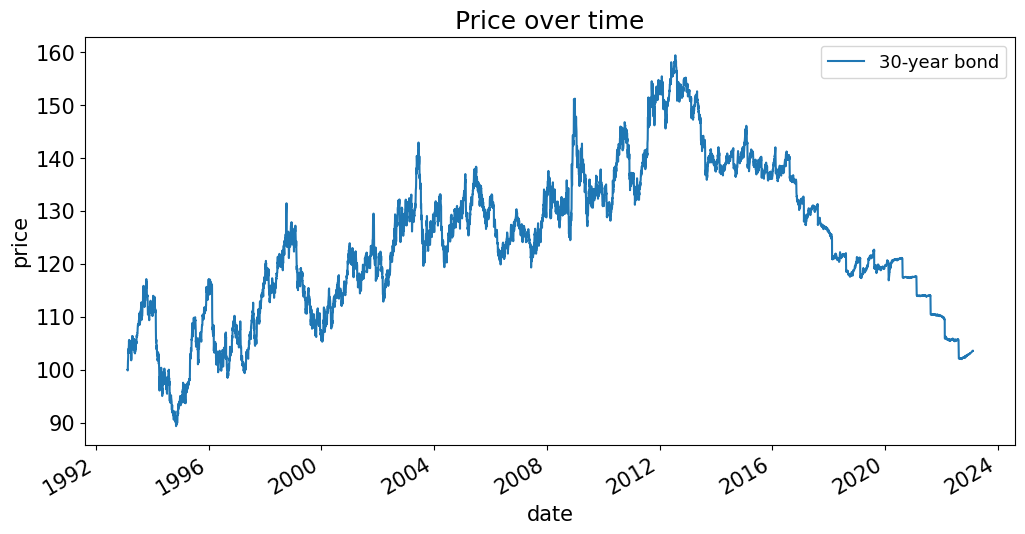

In [3]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
price = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK') + tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
ret = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDRETNUA')

treasnos = ask.columns
ask.columns = cols
ret.columns = cols
price.columns = cols

ymin = price[select].loc[xmin:xmax].min()
ymax = price[select].loc[xmin:xmax].max()

price[select].plot(xlabel='date',ylabel='price',title='Price over time')
plt.legend()
plt.show()

Note that
* the price varies substantially
* there are periods where price is greater than 100 (above par) due to the coupon
* the price since the pandemic has moved nearly in lockstep with coupon payments

Recall that this is the **dirty price** which includes accrued interest of the coupons.

Compare the quoted, **clean ask price** with this dirty price.

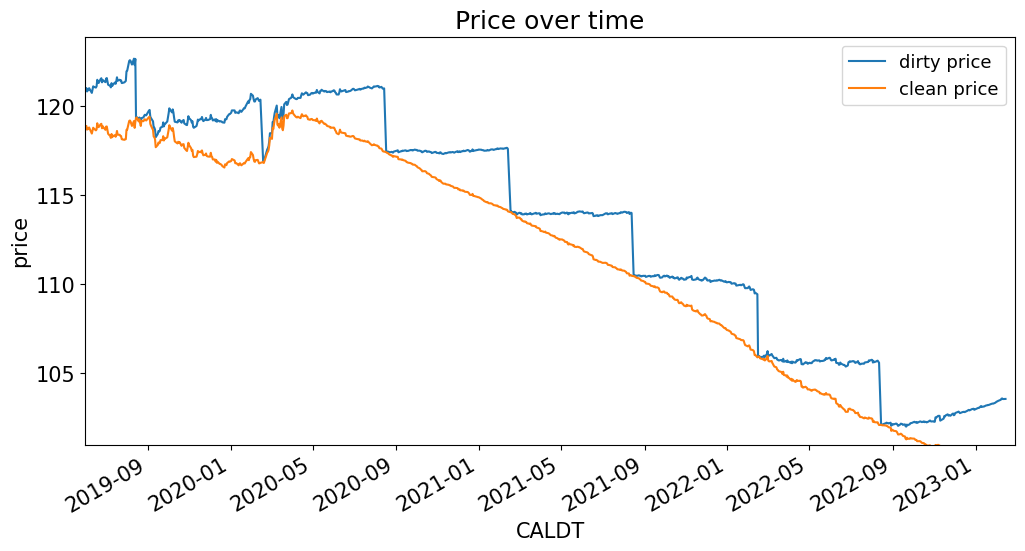

In [4]:
ax = price[select].plot(xlabel='date',ylabel='price',title='Price over time',xlim=(xmin,xmax),ylim=(.99*ymin,1.01*ymax))
ask[select].plot(ax=plt.gca())

plt.legend(['dirty price','clean price'])
plt.show()

Note that the cumulative return is...
* not proportional to the price, due to the coupons
* risky!
* well above/below what the YTM at issue would imply

The YTM is the **annualized average return**


### Prices and returns have little variation since 2020

The price graph above seems odd after March 2020. It goes from volatile to almost deterministic.

The cumulative return graph above goes from volatile to almost constant.

This is not an error, but rather reflects the near-0 volatility of interest rates in that time period.

### Returns
Below, plot the cumulative return of the bond, including coupons.

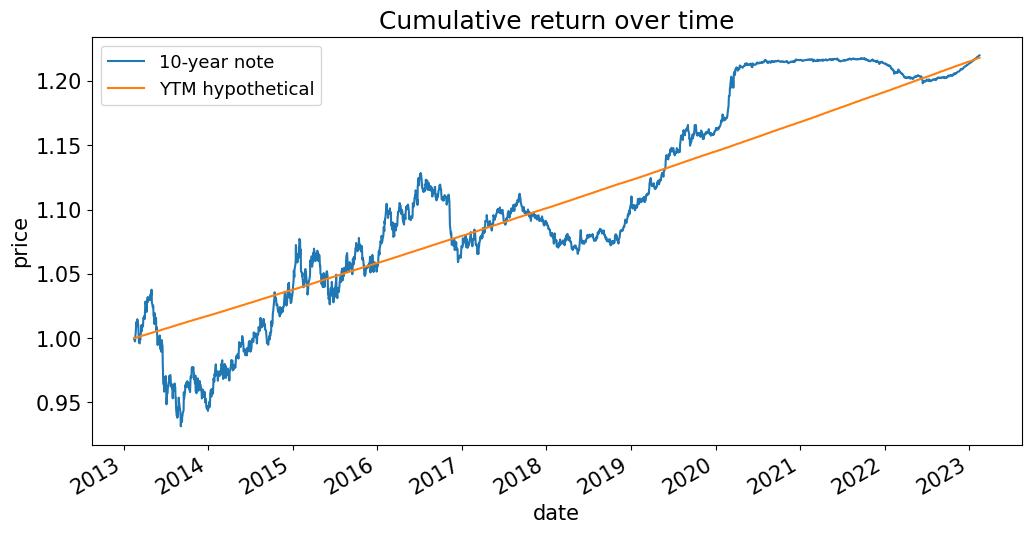

In [5]:
colret = 1

DAYS_YEAR = 365.25
TRADING_DAYS_YEAR = 252
ANNUALIZATION = DAYS_YEAR / TRADING_DAYS_YEAR

yld_initial = tsdata[tsdata['KYTREASNO']==treasnos[colret]].sort_values('CALDT')['TDYLD'].iloc[0] * ANNUALIZATION
ret_hypothetical = pd.DataFrame(index=ret[cols[colret]].dropna().index,columns=['YTM hypothetical'])
for i,dt in enumerate(ret_hypothetical.index):
    ret_hypothetical.loc[dt,'YTM hypothetical'] = (1+yld_initial)**i

(ret[cols[colret]]+1).cumprod().plot(xlabel='date',ylabel='price',title='Cumulative return over time')
ret_hypothetical.plot(ax=plt.gca(),xlabel='date')
plt.legend()
plt.show()

### Extra

In [6]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

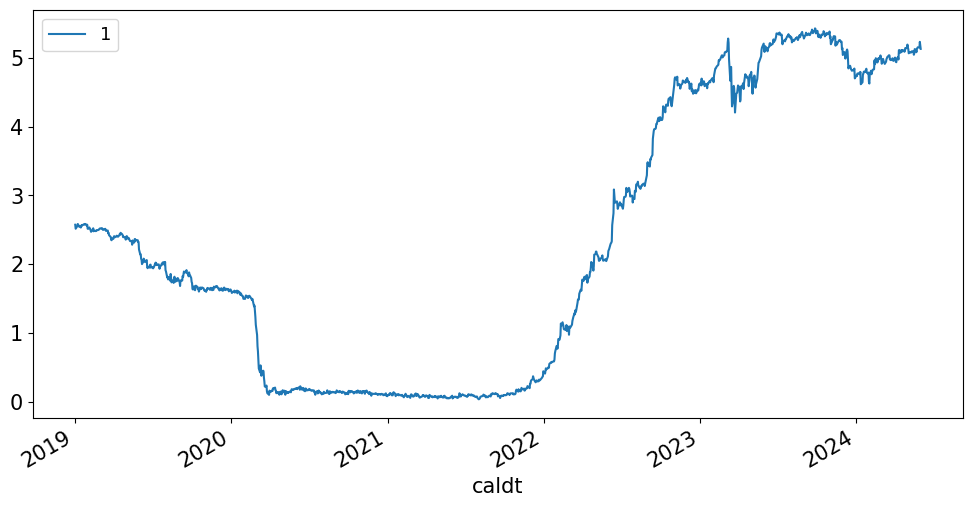

In [7]:
yields[[1]]['2019-01-01':].plot()
plt.show()

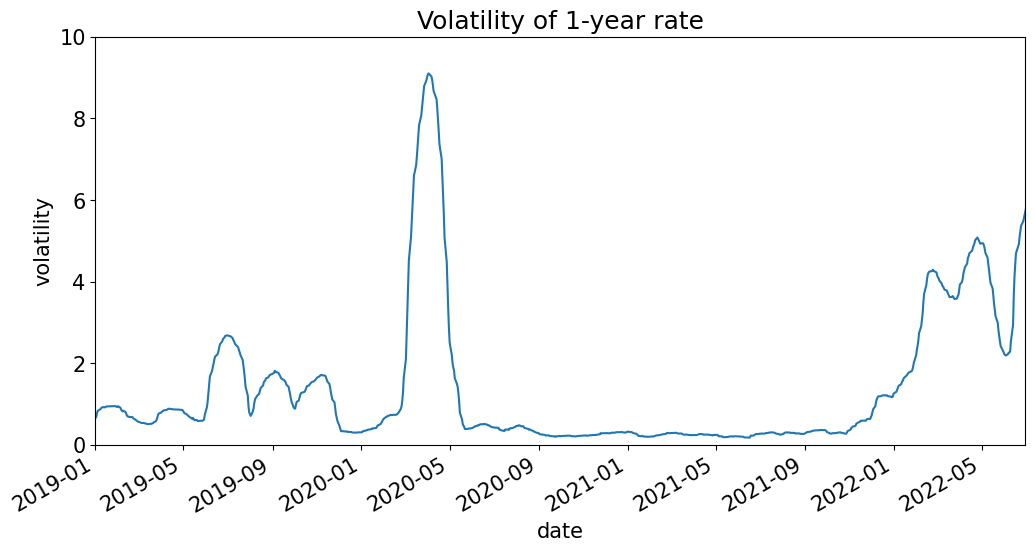

In [8]:
TRADING_DAYS_MONTH = 21
yield_vol = yields[1].rolling(TRADING_DAYS_MONTH * 2).std()*np.sqrt(TRADING_DAYS_YEAR)
yield_vol.plot(xlim=('2019-01-01','2022-06-30'),ylim=(0,10),xlabel='date',ylabel='volatility',title='Volatility of 1-year rate')
plt.show()

### Bills

Consider the price and return of a 4-month T-bill
* interest rates were low and nearly constant during this time.
* market liquidity and frictions cause the price to go over 100

Note that the cumulative return is proportional to the price, (since there are no coupons.)

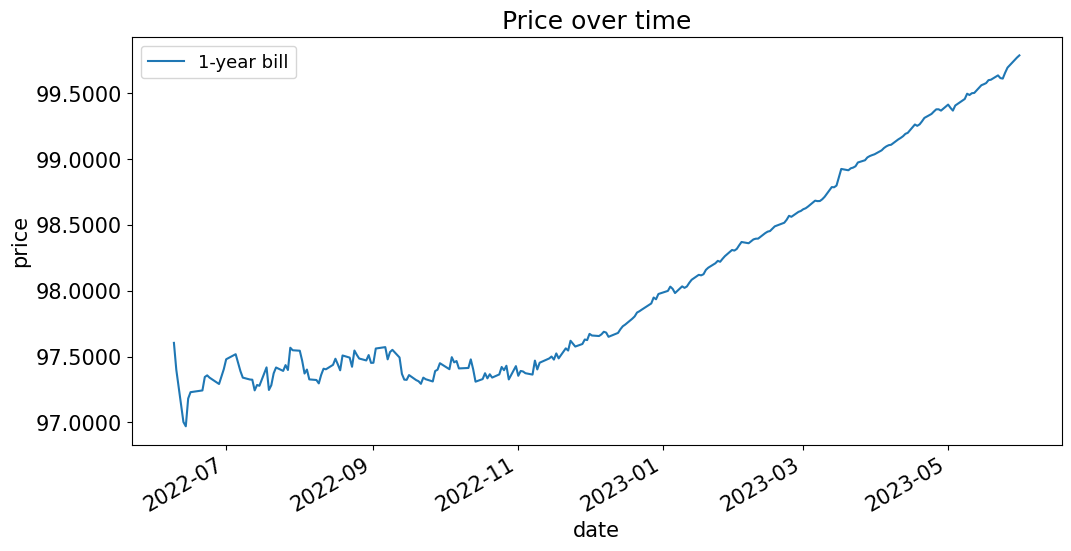

In [9]:
filepath_tsdata = f'../data/treasury_ts_2023-06-15.xlsx'
cols = ['3-year note','1-year bill']
colbill = 1

tsdata_bill = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata_bill.columns = tsdata.columns.str.upper()

ask_bill = tsdata_bill.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
ask_bill.columns = cols
price_bill = tsdata_bill.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK') + tsdata_bill.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
price_bill.columns = cols

ask_bill[cols[colbill]].plot(ylabel='price',title='Price over time',xlabel='date')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.legend()
plt.show()

## TIPS vs Nominal

Consider the movement of TIPS versus nominal notes.

Below shows two 30-year bonds, a TIPS and a nominal, each maturing `2041-02-15`. 

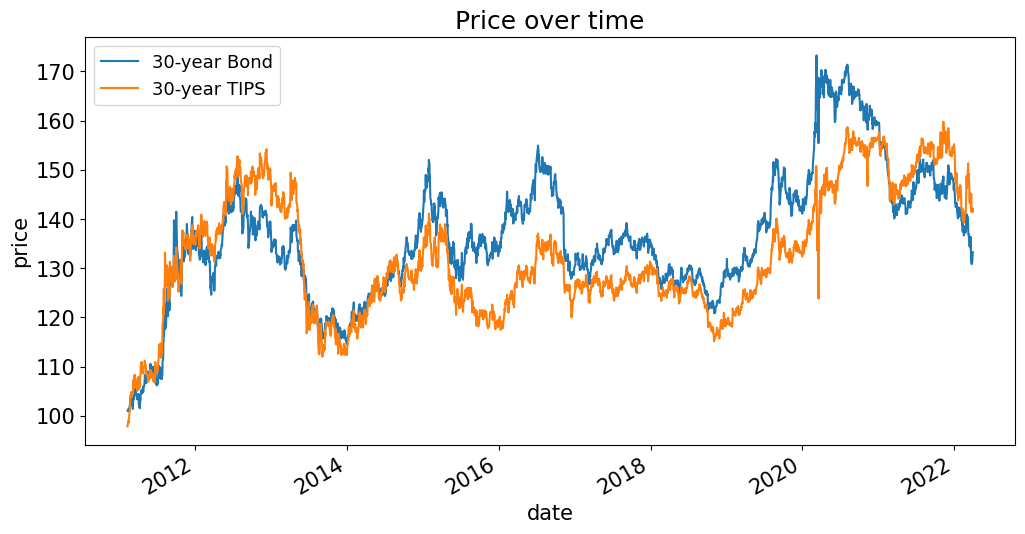

In [10]:
filepath_tsdata = f'../data/treasury_ts_2041-02-15_tips.xlsx'
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
ret = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDRETNUA')

ask.columns = ['30-year Bond','30-year TIPS','20-year Bond']
ret.columns = ['30-year Bond','20-year Bond']

ask[['30-year Bond','30-year TIPS']].plot(ylabel='price',title='Price over time',xlabel='date')
plt.legend()
plt.show()

In [11]:
tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').tail().style.format('{:.2f}')

KYTREASNO,206226,206477,207679
CALDT,,,
2022-03-25 00:00:00,130.84,141.43,87.28
2022-03-28 00:00:00,131.24,142.00,87.80
2022-03-29 00:00:00,132.22,141.56,88.35
2022-03-30 00:00:00,133.11,142.10,88.84
2022-03-31 00:00:00,133.25,141.50,89.23


In [12]:
display(f'Correlation between TIPS and nominal prices over full history: {ask.pct_change().corr().values[0,1]:.2%}')
display(f'Correlation between TIPS and nominal prices over past 3 months: {ask.iloc[-63:,[0,1]].pct_change().corr().values[0,1]:.2%}')

'Correlation between TIPS and nominal prices over full history: 84.11%'

'Correlation between TIPS and nominal prices over past 3 months: 63.90%'

#### Consider the total return since the last coupon date.

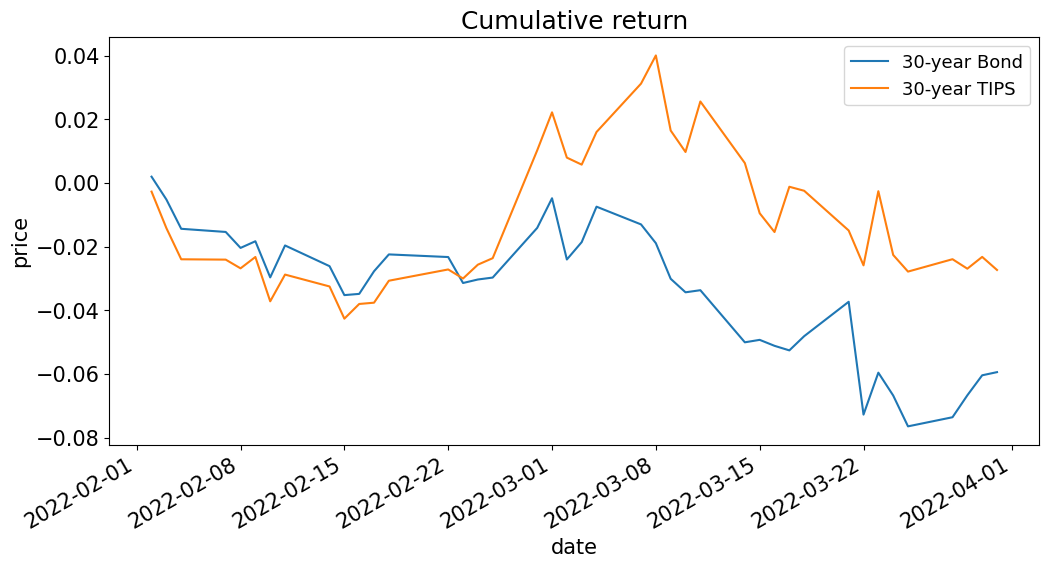

In [13]:
temp = (1+ask.iloc[-42:,[0,1]].pct_change()).cumprod()-1
temp.plot(xlabel='date',ylabel='price',title='Cumulative return');

## Yield Curve Over Time

Of course, changing prices and rates imply the entire yield curve is changing over time.

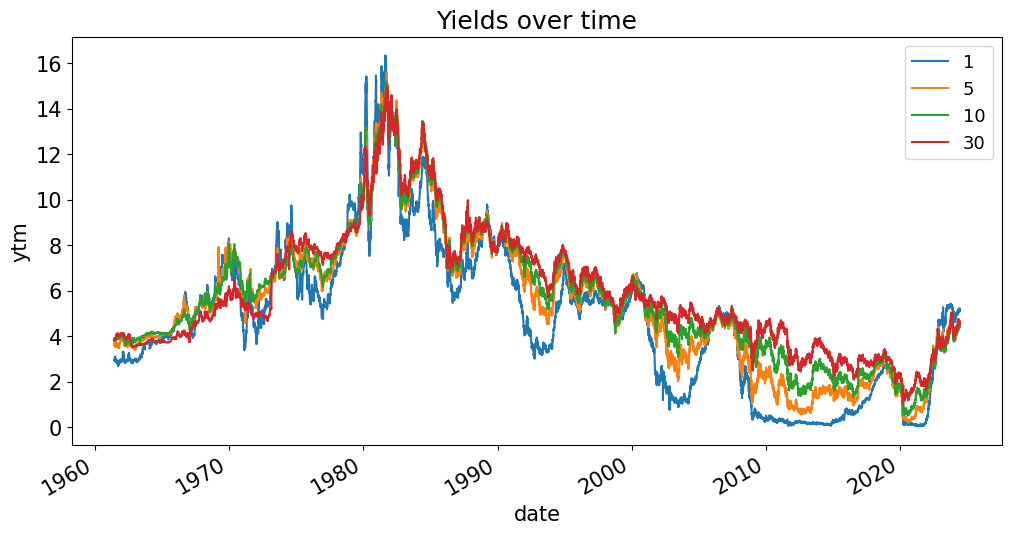

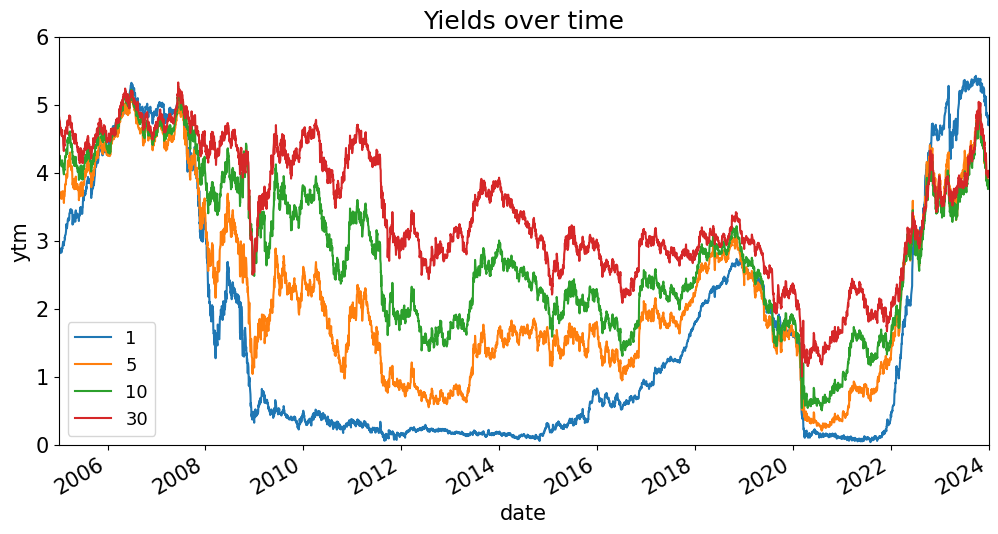

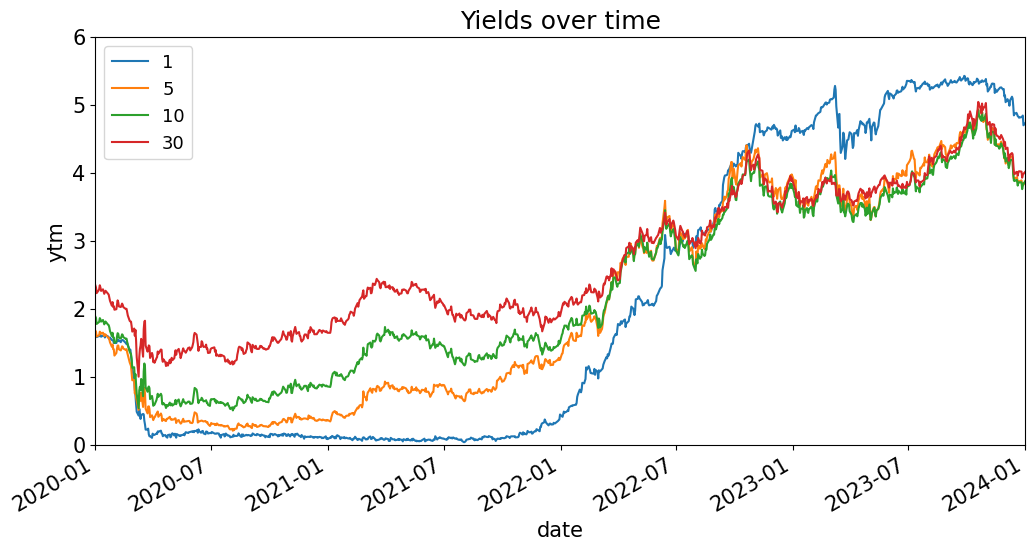

In [14]:
yields[[1,5,10,30]].plot(title='Yields over time',xlabel='date',ylabel='ytm')
yields[[1,5,10,30]].plot(xlim=('2005-01-01','2024-01-01'),ylim=(0,6),title='Yields over time',xlabel='date',ylabel='ytm')
yields[[1,5,10,30]].plot(xlim=('2020-01-01','2024-01-01'),ylim=(0,6),title='Yields over time',xlabel='date',ylabel='ytm')
plt.show()

***

## Shapes of the yield curve

We are interested in sensitivity to the spot curve, but it is closely related to the yield curve.

As is widely done, we will focus on shapes of the yield curve, to avoid needing to repeatedly estimate a spot curve and deal with potential questions around that methodology.

The **yield curve** changes beyond just parallel shifts.

Many of these changes and shapes can be described in terms of the curve's
* level
* slope
* curvature

The figure below shows how these shapes have looked very different across time.

We define 
* level = long-term yield, (often 10 year or 30 year) minus short-term yield (often 1 year or 2 year)
* curvature = Mid-range yield (often 5 year or 10 year) minus short-term yield and minus long-term yield

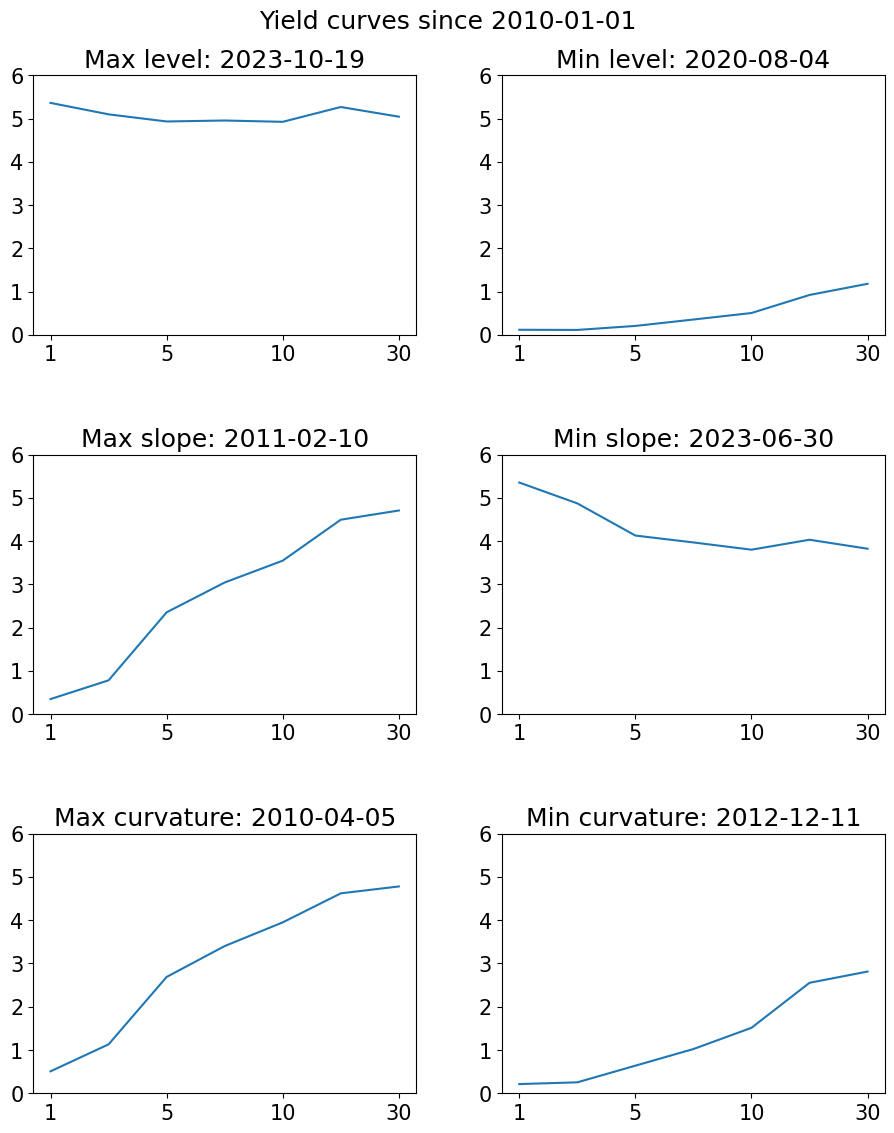

In [15]:
shapes_all = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes_all['slope'] = yields[30]-yields[1]
shapes_all['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapes = shapes_all[shapes_all.index>DATETHRESH]

fig, axs = plt.subplots(3,2,figsize=(10,12))

idx = shapes['level'].idxmax()
lab = f'Max level: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[0,0],title = lab,ylim=(0,6))

idx = shapes['level'].idxmin()
lab = f'Min level: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[0,1],title = lab,ylim=(0,6))

idx = shapes['slope'].idxmax()
lab = f'Max slope: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[1,0],title = lab,ylim=(0,6))

idx = shapes['slope'].idxmin()
lab = f'Min slope: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[1,1],title = lab,ylim=(0,6))

idx = shapes['curvature'].idxmax()
lab = f'Max curvature: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[2,0],title = lab,ylim=(0,6))

idx = shapes['curvature'].abs().idxmin()
lab = f'Min curvature: {yields.loc[idx].name:%Y-%m-%d}'
yields.loc[idx,:].plot(ax=axs[2,1],title = lab,ylim=(0,6))

fig.tight_layout(pad=3.0)
fig.suptitle(f'Yield curves since {DATETHRESH}')
plt.show()

***

## PCA

Principal Component Analysis (PCA) may be helpful in describing these shapes.

PCA gives linear combinations of interest rates along the curve which have maximum explanatory power in its variation.

The yield curve data we're using is specified at **7 maturities, so we have 7 time series.**

In [16]:
yields.tail().style.format('{:.2f}')

,1,2,5,7,10,20,30
caldt,,,,,,,
2024-05-24 00:00:00,5.15,4.88,4.48,4.42,4.41,4.64,4.51
2024-05-28 00:00:00,5.15,4.92,4.55,4.51,4.50,4.74,4.61
2024-05-29 00:00:00,5.23,4.93,4.60,4.57,4.56,4.80,4.68
2024-05-30 00:00:00,5.17,4.88,4.54,4.50,4.50,4.74,4.63
2024-05-31 00:00:00,5.13,4.82,4.47,4.45,4.45,4.71,4.60


PCA analysis will return 7 linear combinations of these yields.

The factors are orthogonal to each other.

They explain decreasing amounts of variance.
* Given the high correlation across these rates, PCA can explain most the total variation with a single factor.

#### The table below shows that the first factor (and certainly the first 3) explain most variation.

In [17]:
pca = PCA(svd_solver='full')
pca.fit(yields)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))
pca_var_explained.style.format('{:.2%}'.format)

,1,2,3,4,5,6,7
Variance explained,97.07%,2.53%,0.29%,0.05%,0.04%,0.02%,0.01%


### Level, slope, and curvature

If we examine the loadings of the PCs on the respective yields, we find that the first three PCs are interpretable as 
* level
* slope
* curvature

Note that this is not a structured result, but rather an empirical regularity of dealing with interest rate data.

It says that the three factors above explain most interest rate variation.

While we could continue to define these factors ad hoc, the PCA estimation of them gives us a more systematic approach.

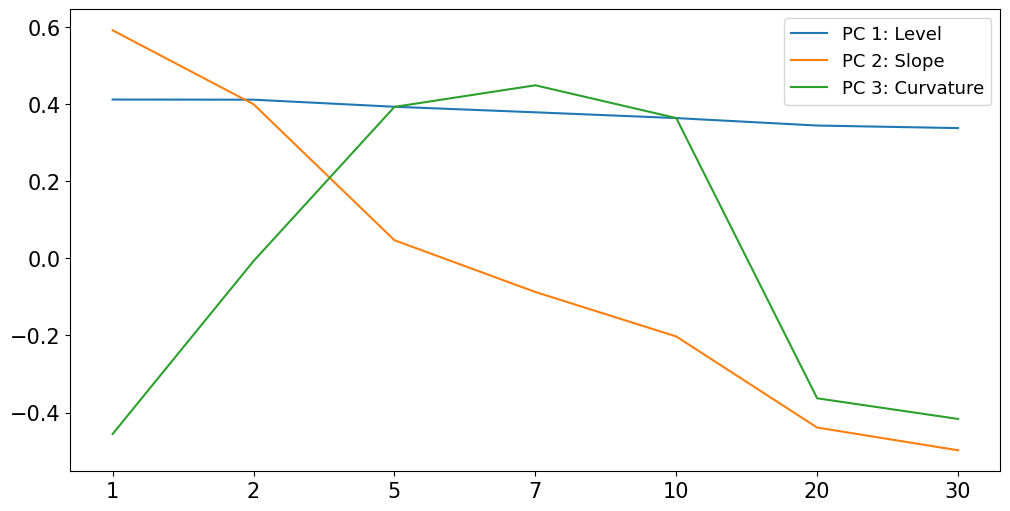

In [18]:
pca_wts = pd.DataFrame(pca.components_,columns=yields.columns)
pca_wts.index = ['PC 1: Level','PC 2: Slope','PC 3: Curvature','PCA 4','PCA 5','PCA 6','PCA 7']
if pca_wts.loc['PC 3: Curvature',10]<0:
    pca_wts.loc['PC 3: Curvature'] *= -1
pca_wts.T.iloc[:,0:3].plot();

In [19]:
pca_wts.style.format('{:.2f}')

,1,2,5,7,10,20,30
PC 1: Level,0.41,0.41,0.39,0.38,0.36,0.34,0.34
PC 2: Slope,0.59,0.40,0.05,-0.09,-0.20,-0.44,-0.50
PC 3: Curvature,-0.46,-0.01,0.39,0.45,0.36,-0.36,-0.42
PCA 4,0.36,-0.39,-0.37,-0.10,0.74,-0.07,-0.14
PCA 5,-0.02,-0.01,0.02,-0.01,-0.05,0.74,-0.67
PCA 6,0.34,-0.57,-0.01,0.64,-0.38,-0.02,0.00
PCA 7,0.17,-0.44,0.74,-0.47,-0.01,-0.01,0.02


For more on factor duration, see the application at the end.

## How similar are PCA and ad-hoc factors?

Try using specified factors:
* Level: average of all yields at a given point in time
* Slope: 30-year minus 10-year yield
* Curvature: 10-year minus 1-year minus 30-year

Build the factors

In [20]:
phi = pd.DataFrame(index=shapes.columns,columns=yields.columns,dtype=float).T

for col in yields.columns:
    phi.loc[col,:] = LinearRegression(fit_intercept=False).fit(shapes_all,yields[col]).coef_

phi.style.format('{:.2f}')

,level,slope,curvature
1,1.00,-0.45,-0.24
2,1.00,-0.39,-0.04
5,1.00,-0.17,0.18
7,1.00,-0.05,0.22
10,1.00,0.05,0.26
20,1.01,0.46,-0.15
30,1.00,0.55,-0.24


### Result is similar to PCA

This demonstrates that PCA is extracting what we think of as level, slope, and curvature.

Note the high correlations on the diagonal of the matrix below, which is comparing
* PCA constructed shocks
* Ad-hoc shape shocks

In [21]:
pca_factors = yields @ pca_wts.T
pd.concat([shapes_all, pca_factors.iloc[:,0:3]], axis=1, keys=['shapes', 'pca']).corr().loc['shapes', 'pca'].style.format('{:.1%}')

,PC 1: Level,PC 2: Slope,PC 3: Curvature
level,100.0%,-1.2%,-0.1%
slope,-38.7%,-91.8%,1.1%
curvature,-17.6%,-64.0%,70.1%
